In [7]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [8]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May 14 13:42:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
!pip install tiktoken

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 23.7 MB/s eta 0:00:00


In [12]:
import numpy as np
import pandas as pd
import requests
import re
import string
import random
from collections import Counter
import nltk
from nltk.tokenize import RegexpTokenizer
import json
import os
import tiktoken 
import openai
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

# Cleaning

GPT3 doesn't need stemming and lemmatizer

In [13]:
def clean_text(text):
    import re
    from string import punctuation
    text=re.sub(r'(http|ftp|https):\/\/([\w\-_]+(?:(?:\.[\w\-_]+)+))([\w\-\.,@?^=%&:/~\+#]*[\w\-\@?^=%&/~\+#])?', 
                ' ', text)
    text=re.sub(r'['+punctuation+']',' ',text)
    text=re.sub(r'#(\w+)',' ',text)
    text=re.sub(r'@(\w+)',' ',text)
    text = text.lower() # Convert  to lowercase

    token=RegexpTokenizer(r'\w+')
    tokens = token.tokenize(text)
    
#    GPT3 doesn't need stemming and lemmatizer    
#    lemmatizer = WordNetLemmatizer()
#    stems = [lemmatizer.lemmatize(t) for t in tokens]
#    stemmer = PorterStemmer()
#    stems = [stemmer.stem(t) for t in stems]
    
    return ' '.join(tokens)

# Open ai environment setup

In [14]:
#!pip install --upgrade openai

Set OpenAI API Key as an environment variable. Having it as an environment variable let's the key live on the computer, but not actually be present in the code.

In [15]:
os.environ["OPENAI_API_KEY"] = "sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"

In [16]:
openai.api_key = os.getenv("OPENAI_API_KEY")

# Zero-shot Classification: 
This method uses a pre-trained model to classify sentiment based on a given prompt, without any training needed. 

This is a quick way to classify data but might not be as accurate as other methods.

Openai Cookbok link: https://github.com/openai/openai-cookbook

In [17]:
COMPLETIONS_MODEL = "text-davinci-003"

def request_completion(prompt):
    completion_response = openai.Completion.create(
        prompt=prompt,
        temperature=0,
        max_tokens=5,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        model=COMPLETIONS_MODEL
    )
    return completion_response

def classify_emotion(text, prompt):
    prompt = prompt.replace('cleaned_text', text)
    classification = request_completion(prompt)['choices'][0]['text'].replace('\n', '')
    return classification.lower()

# Define prompt for classification

In [18]:
emotion_prompt = (
    "Classify the following text as one of the emotions: anger, fear, joy, love, sadness, surprise. "
    "If it's not clear, choose the emotion that is closest to the sentiment from these options: anger, fear, joy, love, sadness, surprise only.\n"
    "Text: cleaned_text\nEmotion:"
)

# Test data

In [20]:
pd.set_option('display.max_colwidth', 160)
test_df = pd.read_csv('/content/drive/MyDrive/DLBBT01/data/b_processed_labeled/test.csv', encoding='utf-8')

test_df['cleaned_text'] = test_df['text'].apply(clean_text)
pd.set_option('display.max_colwidth', 160)
test_df.head()

,text,sentiment,cleaned_text
0,im feeling rather rotten so im not very ambitious right now,sadness,im feeling rather rotten so im not very ambitious right now
1,im updating my blog because i feel shitty,sadness,im updating my blog because i feel shitty
2,i never make her separate from me because i don t ever want her to feel like i m ashamed with her,sadness,i never make her separate from me because i don t ever want her to feel like i m ashamed with her
3,i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived,joy,i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived
4,i was feeling a little vain when i did this one,sadness,i was feeling a little vain when i did this one


In [21]:
len(test_df)

4170

# Divide into smaller chunks

open ai text-davinci-003 has a token limit of 4096 tokens per API call.

About 1.5 tokens per-word.

4096 tokens / 1.5 tokens per word ≈ 2730 words

In [23]:
import pandas as pd
import os

file_path = '/content/drive/MyDrive/DLBBT01/data/a_raw_labeled/test.csv'
df = pd.read_csv(file_path)

# Split the data into 7 chunks
num_chunks = 7
chunk_size = len(df) // num_chunks

chunks = []
for i in range(num_chunks - 1):
    chunk = df.iloc[i * chunk_size : (i + 1) * chunk_size]
    chunks.append(chunk)
chunks.append(df.iloc[(num_chunks - 1) * chunk_size :])

# Save the chunks as separate CSV files
for idx, chunk in enumerate(chunks, 1):
    output_file_path = r'/content/drive/MyDrive/DLBBT01/data/b_processed_labeled/chunks/test{}.csv'.format(idx)
    chunk.to_csv(output_file_path, index=False)

In [25]:
test_df['label'] = test_df['cleaned_text'].apply(lambda text: classify_emotion(text, emotion_prompt))
test_df.to_csv('/content/drive/MyDrive/DLBBT01/data/b_processed_labeled/test_classified.csv', 
             encoding='utf-8', index=False)
print('done')

done


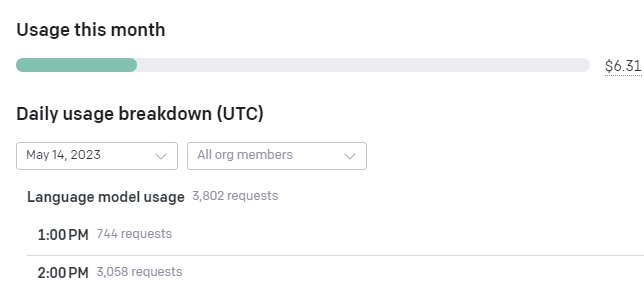

In [67]:
test_df = pd.read_csv('/content/drive/MyDrive/DLBBT01/data/b_processed_labeled/test_classified.csv',encoding='utf-8')

In [68]:
test_df = test_df[['text','label','sentiment']]
test_df.head()

,text,label,sentiment
0,im feeling rather rotten so im not very ambitious right now,sadness,sadness
1,im updating my blog because i feel shitty,sadness,sadness
2,i never make her separate from me because i don t ever want her to feel like i m ashamed with her,love,sadness
3,i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived,joy,joy
4,i was feeling a little vain when i did this one,joy,sadness


In [69]:
num_missing = test_df['label'].isnull().sum()
print("Number of missing values in 'label' column: ", num_missing)

Number of missing values in 'label' column:  0


In [70]:
test_df.dropna(subset=['label'], inplace=True)

In [71]:
#labeling
reviews = np.array(test_df['text'])[:]
sentiments = np.array(test_df['sentiment'])[:]
Counter(sentiments)

Counter({'sadness': 695,
         'joy': 695,
         'fear': 695,
         'anger': 695,
         'love': 695,
         'surprise': 695})

In [72]:
#labeling
reviews = np.array(test_df['text'])[:]
labels = np.array(test_df['label'])[:]
Counter(labels)

Counter({' sadness': 1121,
         ' love': 341,
         ' joy': 1352,
         ' fear': 710,
         ' anger': 371,
         ' none of the above': 15,
         ' surprise': 222,
         ' exhaustion': 1,
         ' uncertainty': 4,
         ' sympathy/love': 7,
         ' jealousy (not one of': 3,
         ' curiosity': 12,
         ' pride': 1,
         ' determination': 1,
         ' sympathy': 8,
         ' neutral': 1})

In [73]:
# Create a dictionary for replacements
replacement_dict = {
    " none of the above": " surprise",
    " exhaustion": " anger",
    " uncertainty": " fear",
    " sympathy/love": " love", 
    " jealousy (not one of": " anger", 
    " curiosity": " surprise", 
    " pride": " anger",
    " determination": " surprise",
    " sympathy": " love", 
    " neutral": " surprise",
    " surprise": " surprise"
}

# Use the replace function 
test_df['label'] = test_df['label'].replace(replacement_dict)

# Print the new counts
print(test_df['label'].value_counts())


 joy         1352
 sadness     1121
 fear         714
 anger        376
 love         356
 surprise     251
Name: label, dtype: int64


# **Classification Report**

              precision    recall  f1-score   support

       anger       0.81      0.44      0.57       695
        fear       0.57      0.59      0.58       695
         joy       0.36      0.71      0.48       695
        love       0.54      0.28      0.37       695
     sadness       0.42      0.67      0.52       695
    surprise       0.75      0.27      0.40       695

    accuracy                           0.49      4170
   macro avg       0.57      0.49      0.48      4170
weighted avg       0.57      0.49      0.48      4170



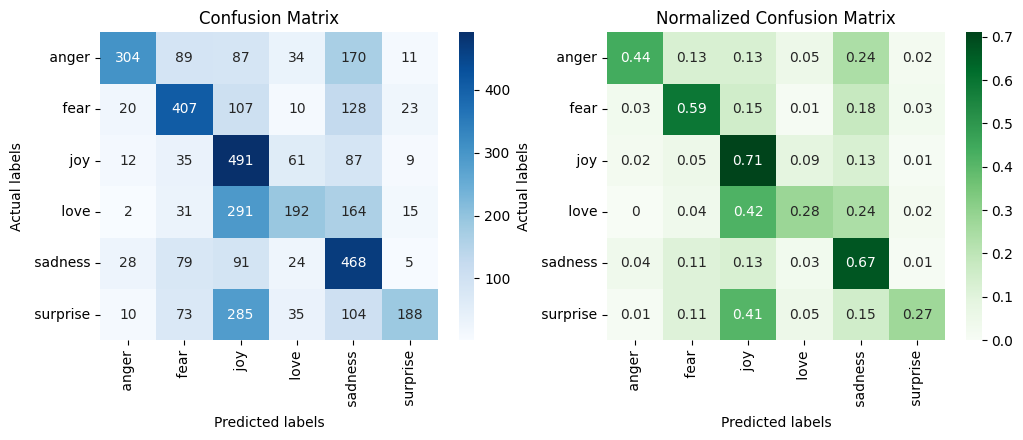

In [74]:
# Select the relevant columns from the DataFrame
test_df = test_df[['text', 'label', 'sentiment']]

# Encode the labels and sentiments
le = LabelEncoder()
le.fit(test_df['label'])
y_pred = le.transform(test_df['label'])
class_labels = le.classes_

le.fit(test_df['sentiment'])
y_true = le.transform(test_df['sentiment'])

# Print the classification report
class_report = classification_report(y_true, y_pred, target_names=class_labels, zero_division=1)
print(class_report)

# Create and display the confusion matrix and normalized confusion matrix side by side
conf_mat = confusion_matrix(y_true, y_pred)
conf_mat_norm = np.around(conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis], decimals=2)
conf_mat_norm = np.nan_to_num(conf_mat_norm)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=ax1)
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('Actual labels')
ax1.set_title('Confusion Matrix')

sns.heatmap(conf_mat_norm, annot=True, cmap='Greens', fmt='g', xticklabels=class_labels, yticklabels=class_labels, ax=ax2)
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('Actual labels')
ax2.set_title('Normalized Confusion Matrix')

plt.show()